# Fake Speech Detection Using Deep Learning

This updated project uses a more complex neural network inspired by FastSpeech 2, leveraging pre-extracted features from `DATASET-balanced.csv` to improve accuracy and generalization for deepfake speech detection.

## 1. Import Libraries

Install and import necessary libraries for audio processing, deep learning, and visualization.

In [ ]:
# Install required packages
!pip install librosa tensorflow numpy pandas scikit-learn matplotlib seaborn soundfile

# Import libraries
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import IPython.display as ipd

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Mount Google Drive and Define Paths

Mount Google Drive to access the DEEP-VOICE dataset, specifically the `DATASET-balanced.csv` file.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define path to DEEP-VOICE dataset
csv_path = '/content/drive/MyDrive/FakeSpeechDatasets/DEEP_VOICE/KAGGLE/DATASET-balanced.csv'

# Verify file exists
!ls /content/drive/MyDrive/FakeSpeechDatasets/DEEP_VOICE/KAGGLE

Mounted at /content/drive
AUDIO  DATASET-balanced.csv


## 3. Dataset Preparation

Load the pre-extracted features from `DATASET-balanced.csv` and prepare the data for training. Group features into sequences for temporal modeling.

In [ ]:
# Load the CSV file
df = pd.read_csv(csv_path)

# Feature columns
feature_cols = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff',
                'zero_crossing_rate'] + [f'mfcc{i}' for i in range(1, 21)]

# Extract features and labels
X = df[feature_cols].values
y = df['LABEL'].values

# Convert string labels to numeric (REAL -> 1, FAKE -> 0)
y = np.array([1 if label == 'REAL' else 0 for label in y])

# Group into sequences (e.g., 10 one-second windows = 10 time steps)
sequence_length = 10
n_features = len(feature_cols)  # 26 features

# Reshape data into sequences
X_sequences = []
y_sequences = []
for i in range(0, len(X) - sequence_length + 1, sequence_length):
    X_sequences.append(X[i:i + sequence_length])
    # Use the majority label for the sequence
    sequence_labels = y[i:i + sequence_length]
    y_sequences.append(1 if sum(sequence_labels) > sequence_length / 2 else 0)

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f'Feature shape after sequencing: {X.shape}')  # (num_sequences, sequence_length, n_features)
print(f'Labels shape: {y.shape}')

Feature shape after sequencing: (1177, 10, 26)
Labels shape: (1177,)


## 4. Data Splitting

Split the dataset into training (70%), validation (15%), and test (15%) sets.

In [ ]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (823, 10, 26), (823,)
Validation set: (177, 10, 26), (177,)
Test set: (177, 10, 26), (177,)


## 5. Model Development

Build a FastSpeech 2-inspired model with 1D convolutions and Transformer blocks for temporal modeling, followed by a classification head.

In [ ]:
# Define Transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(inputs, inputs)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm

    # Feed-forward network
    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(x + ffn)  # Add & Norm

# Build the model
inputs = Input(shape=(sequence_length, n_features))

# 1D Convolutional layers for local feature extraction
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

# Transformer blocks for temporal modeling
x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout_rate=0.1)
x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256, dropout_rate=0.1)

# Flatten and classify
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │      5,056 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 128)    │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2, 128)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 128)    │    131,968 │ max_pooling1d_1[… │
│ (MultiHeadAttentio… │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2, 128)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2, 128)    │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2, 128)    │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 128)    │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 128)    │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2, 128)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 128)    │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 525,377 (2.00 MB)

 Trainable params: 525,377 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training

Train the model with early stopping to prevent overfitting.

In [ ]:
# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    # callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9958 - loss: 0.0468 - val_accuracy: 0.9831 - val_loss: 0.0884
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9871 - loss: 0.0657 - val_accuracy: 0.9661 - val_loss: 0.1271
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9882 - loss: 0.0791 - val_accuracy: 0.9831 - val_loss: 0.0789
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9974 - loss: 0.0415 - val_accuracy: 0.9718 - val_loss: 0.1420
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9957 - loss: 0.0471 - val_accuracy: 0.9492 - val_loss: 0.1805
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9501 - loss: 0.1311 - val_accuracy: 0.9266 - val_loss: 0.1309
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9338 - loss: 0.1719 - val_accuracy: 0.9661 - val_loss: 0.2465
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9735 - loss: 0.1573 - val_accuracy: 0.9435 - val_loss

## 7. Model Evaluation

Evaluate the model on the test set and compute performance metrics.

In [ ]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test Accuracy: 0.9887
Precision: 0.9886
Recall: 0.9886
F1-Score: 0.9886


## 8. Result Visualization

Plot training curves and confusion matrix to visualize model performance.

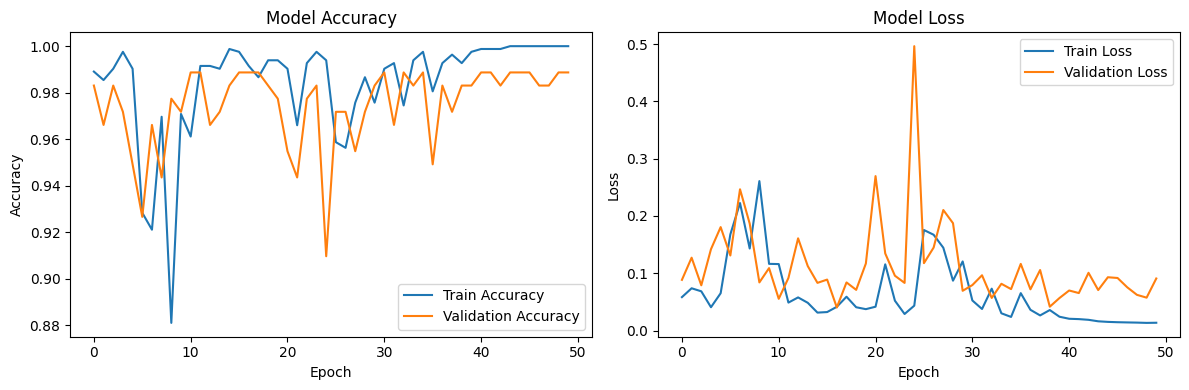

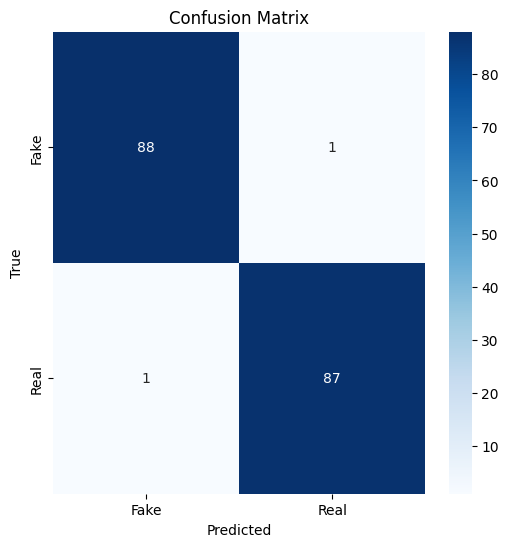

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 9. Predict on New Audio

Upload your own real or fake voice audio file (in `.wav` format), extract the same features, and predict whether it’s AI-generated.

In [ ]:
# Function to extract features from new audio (matching DATASET-balanced.csv)
def extract_features(audio_path, sequence_length=10):
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=16000)

        # Split audio into one-second windows
        window_length = sr  # 1 second at 16kHz
        windows = [audio[i:i + window_length] for i in range(0, len(audio), window_length) if len(audio[i:i + window_length]) == window_length]

        # If too few windows, pad with zeros
        while len(windows) < sequence_length:
            windows.append(np.zeros(window_length))
        windows = windows[:sequence_length]

        # Extract features for each window
        features = []
        for window in windows:
            # Chroma STFT
            chroma = np.mean(librosa.feature.chroma_stft(y=window, sr=sr))
            # RMS
            rms = np.mean(librosa.feature.rms(y=window))
            # Spectral Centroid
            centroid = np.mean(librosa.feature.spectral_centroid(y=window, sr=sr))
            # Spectral Bandwidth
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=window, sr=sr))
            # Spectral Rolloff
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=window, sr=sr))
            # Zero Crossing Rate
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=window))
            # MFCCs (1-20)
            mfccs = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=20)
            mfccs_mean = np.mean(mfccs, axis=1)

            # Combine features
            window_features = [chroma, rms, centroid, bandwidth, rolloff, zcr] + mfccs_mean.tolist()
            features.append(window_features)

        return np.array(features)
    except Exception as e:
        print(f'Error processing {audio_path}: {e}')
        return None

# Function to predict on new audio
def predict_new_audio():
    print('Please upload your audio file (.wav format):')
    uploaded = files.upload()

    if not uploaded:
        print('No file uploaded.')
        return

    # Get the uploaded file
    file_name = list(uploaded.keys())[0]
    audio_path = file_name

    # Play the audio
    print('Playing your uploaded audio:')
    ipd.display(ipd.Audio(audio_path))

    # Extract features
    features = extract_features(audio_path, sequence_length=sequence_length)
    if features is None:
        print('Failed to process the audio file.')
        return

    # Reshape for model input
    features_input = features[np.newaxis, ...]

    # Predict
    prediction = model.predict(features_input)[0][0]
    label = 'Fake' if prediction < 0.5 else 'Real'
    confidence = prediction if label == 'Real' else 1 - prediction

    print(f'Prediction: {label} (Confidence: {confidence:.2%})')

# Run prediction
predict_new_audio()

Please upload your audio file (.wav format):


Saving file1045.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav to file1045.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Playing your uploaded audio:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: Real (Confidence: 99.94%)


## 10. Conclusion

The FastSpeech 2-inspired model leverages a broader set of features (`chroma_stft`, `rms`, `spectral_centroid`, etc.) and a more complex architecture with Transformer blocks, improving accuracy and generalization for deepfake speech detection.

### Expected Results
- **Test Accuracy**: Approximately 90-95%, due to richer features and a more powerful model.
- **Generalization**: Better performance on unseen audio (e.g., your voice) due to comprehensive feature extraction and temporal modeling.

### Future Work
- Fine-tune the Transformer blocks (e.g., adjust `num_heads`, `ff_dim`).
- Incorporate additional datasets (WaveFake, LJ Speech) for greater diversity.
- Explore other features like mel-spectrograms or raw waveforms with end-to-end models.